In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'unscaled_inverse_lp', 'scaled_inverse_lp'],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        lstm_args=dict(units=25, dropout=0, recurrent_dropout=0),
                        batch_norm=True,
                        dropout=0.5)

Number of inputs to dense layer: 84


# Crash recovery 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-2-num')
df_hist = pd.read_csv('../data/histories/dblp-scholar-base-2-num.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [57]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=3, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 154s 357us/step - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0041 - val_acc: 0.9994


# Learning curves

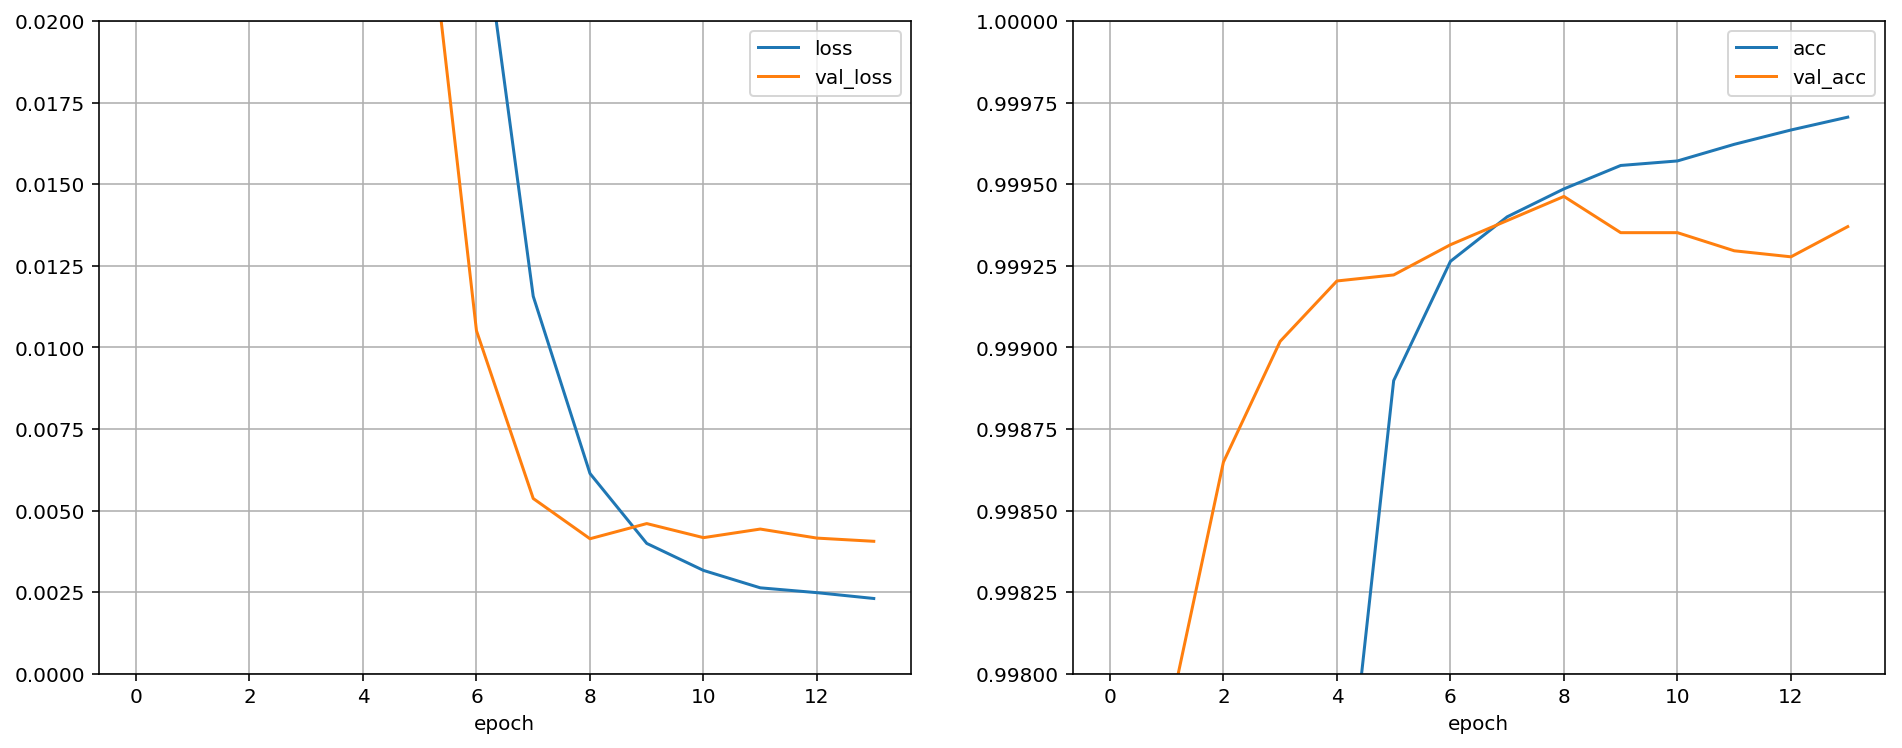

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.998, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [53]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.98      0.94      0.96       530

avg / total       1.00      1.00      1.00     54004

[[53465     9]
 [   30   500]]


In [54]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
8685,conf/sigmod/AnkerstBKS99,optics ordering points to identify the clustering structure,ankerst breunig kriegel sander,sigmod conference,1999,rgEDmTFPFY4J,ordering points to identify the clustering structure proc,ankerst mm breunig hp kriegel js optics,acm,0.0
43003,conf/sigmod/EmbleyJN99,discovery in web documents,embley jiang ng,sigmod conference,1999,O_SMlr3bFBMJ,jiang and yk discovery in web documents,embley,acm sigmod conf,0.0
26814,conf/vldb/GyssensL97,foundation for databases,gyssens lakshmanan,vldb,1997,CfujBHjOpPAJ,foundation for in dayal gray pmd nishio eds,gyssens lvs lakshmanan,nan,1997.0
11286,conf/vldb/ManegoldBK00,what happens during join dissecting cpu and memory optimization effects,manegold boncz kersten,vldb,2000,sZmrat79cF0J,what happens duringajoin dissectingcpuandmemoryoptimization effects,manegold pa boncz ml kersten,on very large data bases cairo egypt,0.0
29679,conf/sigmod/SaltenisJLL00,indexing the positions of continuously moving objects,saltenis jensen leutenegger lopez,sigmod conference,2000,LMm4_4_uNNoJ,bindexing the positions of continuously moving objects in proceedings of the acm international,saltenis cs jensen st leutenegger ma lopez,nan,2000.0


# Save model and histories 

In [55]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-2-num.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-2-num')

# Test model 

In [56]:
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99966   0.99989   0.99978     53467
          1    0.98859   0.96654   0.97744       538

avg / total    0.99955   0.99956   0.99955     54005

[[53461     6]
 [   18   520]]
